<a href="https://colab.research.google.com/github/Tharusha-Sihan/BSP-Paper-Implementation/blob/main/emd_eemd_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb
!pip install EMD-signal
!pip install antropy

from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
100.atr    105.atr  111.atr  116.dat  122.atr  202.dat	209.at_  214.xws  221.xws  231.xws
100.dat    105.dat  111.dat  116.hea  122.dat  202.hea	209.atr  215.at_  222.at_  232.atr
100.hea    105.hea  111.hea  116.xws  122.hea  202.xws	209.dat  215.atr  222.atr  232.dat
100.xws    105.xws  111.xws  117.at_  122.xws  203.at-	209.hea  215.dat  222.dat  232.hea
101.atr    106.atr  112.atr  117.atr  123.atr  203.at_	209.xws  215.hea  222.hea  232.xws
101.dat    106.dat  112.dat  117.dat  123.dat  203.atr	210.atr  215.xws  222.xws  233.atr
101.hea    106.hea  112.hea  117.hea  123.hea  203.dat	210.dat  217.atr  223.atr  233.dat
101.xws    106.xws  112.xws  117.xws  123.xws  203.hea	210.hea  217.dat  223.dat  233.hea
102-0.atr  107.atr  113.atr  118.atr  124.atr  203.xws	210.xws  217.hea  223.hea  233.xws
102.atr    107.dat  113.dat  118.dat  124.dat  205.atr	212.at

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import antropy as ant

from numpy.linalg import svd
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from PyEMD import EMD, EEMD
# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Define the path to the dataset directory in your Google Drive
path = '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0/'

In [3]:
# Define parameters

SEGMENT_SIZE = 300
TRAIN_SET_SIZE = 50
TEST_SET_SIZE = 20
EMD_IMFS = 5
EEMD_IMFS = 7

In [4]:
#### Function definitions

## Preprocessing

# Mean bias correction
def bias_correction(signal):
    return signal - np.mean(signal)

# Moving average filter
def MA_filter(signal, window_size=6):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# High pass filter
def HP_filter(signal, cutoff=1, fs=360, order=6):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='high', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # Apply filter
    return filtered_signal

# Low pass filter
def LP_filter(signal, cutoff=45, fs=360, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # forward backward filtering
    return filtered_signal

# Denoising
def denoise(signal):
    stage1 = bias_correction(signal)
    stage2 = MA_filter(stage1)
    stage3 = HP_filter(stage2)
    stage4 = LP_filter(stage3)
    return stage4

## Feature extraction

# Initializing EMD
emd = EMD(spline_kind ="cubic")

# Initializing EEMD
eemd = EEMD()

# Extracting the feature vector from a set of IMFs
def extract_features(IMFs):
    # Combine all features into a feature vector
    feature_vector = []
    for imf in IMFs[:-1]:
        # Calculate Sample Entropy
        sampEn = ant.sample_entropy(imf)

        # Calculate Coefficient of Variation (CV)
        mean_imf = np.mean(imf)
        std_imf = np.std(imf)
        CV = (std_imf / mean_imf) ** 2

        # Perform SVD and extract singular value
        singular_value = svd(imf.reshape(-1, 1), compute_uv=False)[0]

        # Calculate Band Power
        bp_value = np.mean(np.square(imf))

        features = [sampEn, CV, singular_value, bp_value]
        feature_vector = np.concatenate((feature_vector,features))
    return feature_vector

# Extracting features data fram from an input dataframe
def get_features_df(input_df, decompose):
    print("Started extracting features")
    all_features_df = pd.DataFrame()
    for i in range(input_df.shape[0]):
        X_i = input_df.iloc[i, :-1].to_numpy()
        y_i = input_df.iloc[i,-1]

        if (decompose == "eemd"):
            IMFs = eemd (X_i, max_imf = EEMD_IMFS)
        elif (decompose == "emd"):
            IMFs = emd(X_i, max_imf = EMD_IMFS)
        else:
            print(f"Error: Invalid decomposition method '{decompose}' provided")
            break
        print(f"Decomposed segment {i}", end='; ')

        features_i = extract_features(IMFs)
        print(f"Extracted features from segment {i}", end='; ')
        features_i = np.append(features_i, y_i)
        feature_df = pd.DataFrame([features_i])
        print(f"Created a dataframe for segment {i}.")
        all_features_df = pd.concat([all_features_df, feature_df], ignore_index=True)

    print("Finished extracting features")
    print() # Print an empty space
    return all_features_df

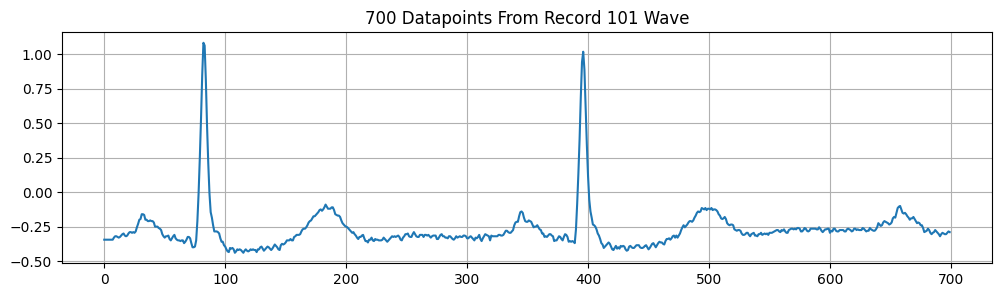

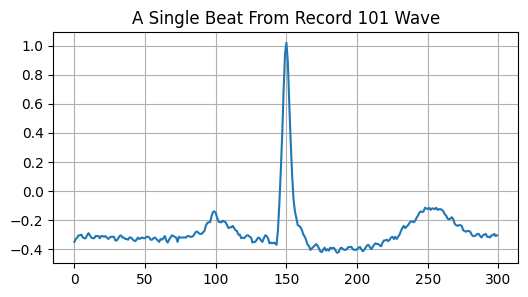


(100018, 300) (100018,)
Class distribution: [75017, 8071, 7255, 2546, 7129]


In [5]:
# Segment size
window_size = SEGMENT_SIZE

# Define arrhythmia classes
classes = ['N', 'L', 'R', 'A', 'V']  # Normal, Left Bundle Branch Block (LBBB), Right Bundle Branch Block (RBBB), Atrial Premature (AP), Ventricular Premature (VP)
n_classes = len(classes)
count_classes = [0] * n_classes

# Initialize lists to store beats and labels
X = list()
y = list()

# Fetch record files from the dataset directory
filenames = next(os.walk(path))[2]
filenames.sort()

# Process each record and annotation
for filename in filenames:
    example_beat_printed = False
    # Only process .dat files (the signal data files)
    if filename.endswith('.dat'):
        record_name = filename.split('.')[0]

        # Read the record (signals) and annotations
        record = wfdb.rdrecord(path + record_name)
        annotation = wfdb.rdann(path + record_name, 'atr')

        signals = record.p_signal[:, 0]  # Taking Lead I for simplicity

        # Process the annotations to extract beats
        for i in range(len(annotation.sample)):
            arrhythmia_type = annotation.symbol[i]

            # Plot an example to the signals
            if i == 1 and record_name == '101':
                # Plot each patient's signal
                plt.figure(figsize=(12, 3))
                plt.title(f"700 Datapoints From Record {record_name} Wave")
                plt.plot(signals[0:700])
                plt.grid(True)
                plt.show()

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                pos = annotation.sample[i]  # Position of the R-peak (sample index)

                # Ensure we don't go out of bounds when extracting the beat
                if window_size//2 <= pos < len(signals) - window_size//2:
                    beat = signals[pos-window_size//2:pos+window_size//2]

                    # Plot an example beat (once)
                    if record_name == '101' and not example_beat_printed:
                        print() # Print an empty space before figure
                        plt.figure(figsize=(6, 3))
                        plt.title(f"A Single Beat From Record {record_name} Wave")
                        plt.plot(beat)
                        plt.grid(True)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)  # 300 point ECG vectors
                    y.append(arrhythmia_index)  # Arrhythmia class labels
                    count_classes[arrhythmia_index] += 1

print() # Print an empty space
print(np.shape(X), np.shape(y))
print("Class distribution:", count_classes)

In [6]:
# Creating a data frame
X_df = pd.DataFrame(X)
X_df[len(X[0])] = y
X_df.shape

(100018, 301)

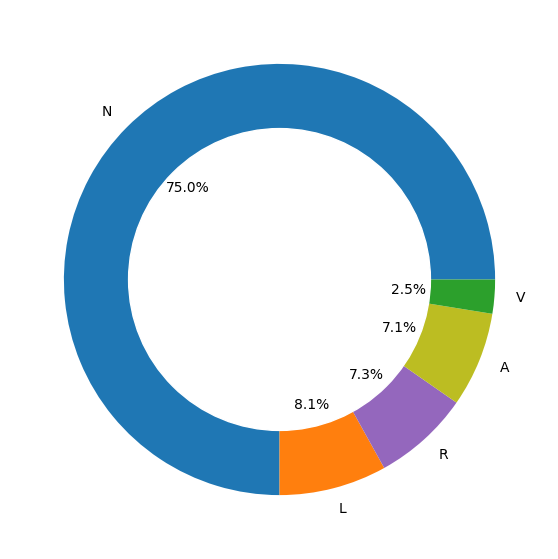

In [7]:
# Distribution of data
per_class = X_df[X_df.shape[1]-1].value_counts()

plt.figure(figsize=(7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [8]:
# Resampling the dataset to get to an even distribution
# TEST_SET_SIZE test data and TRAIN_SET_SIZE training data from each class
n_train = TRAIN_SET_SIZE
n_test = TEST_SET_SIZE
n_total = n_train + n_test

test_ratio = n_test/(n_total)

train = pd.DataFrame()
test = pd.DataFrame()

for class_value in range(5):

    # Filter the dataframe for the current class
    df_class = X_df[X_df[300] == class_value]

    # Randomly sample 2500 rows (or all rows if less )
    df_sampled_class = df_class.sample(n=min(n_total, len(df_class)), random_state=42)

    train_class, test_class = train_test_split(df_sampled_class, test_size= test_ratio)

    # Append the sampled rows to the new dataframe
    train = pd.concat([train, train_class])
    test = pd.concat([test, test_class])

# Reset index of the new dataframe
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Display the new dataframe
train.shape, test.shape

((250, 301), (100, 301))

In [9]:
per_class = train[train.shape[1]-1].value_counts()
print(per_class)

300
0    50
1    50
2    50
3    50
4    50
Name: count, dtype: int64


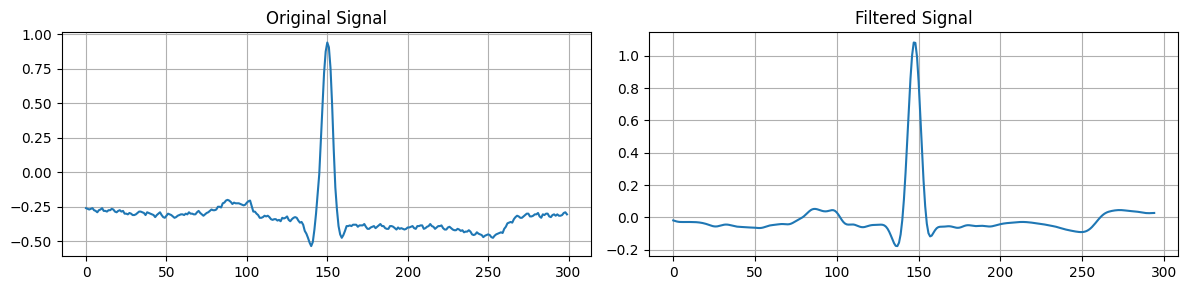

In [10]:
X_filtered = denoise(X[0])

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 1 rows, 2 columns

# Plot the original signal in the first subplot
axs[0].plot(X[0])
axs[0].set_title('Original Signal')
axs[0].grid(True)

# Plot the filtered signal in the second subplot
axs[1].plot(X_filtered)
axs[1].set_title('Filtered Signal')
axs[1].grid(True)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

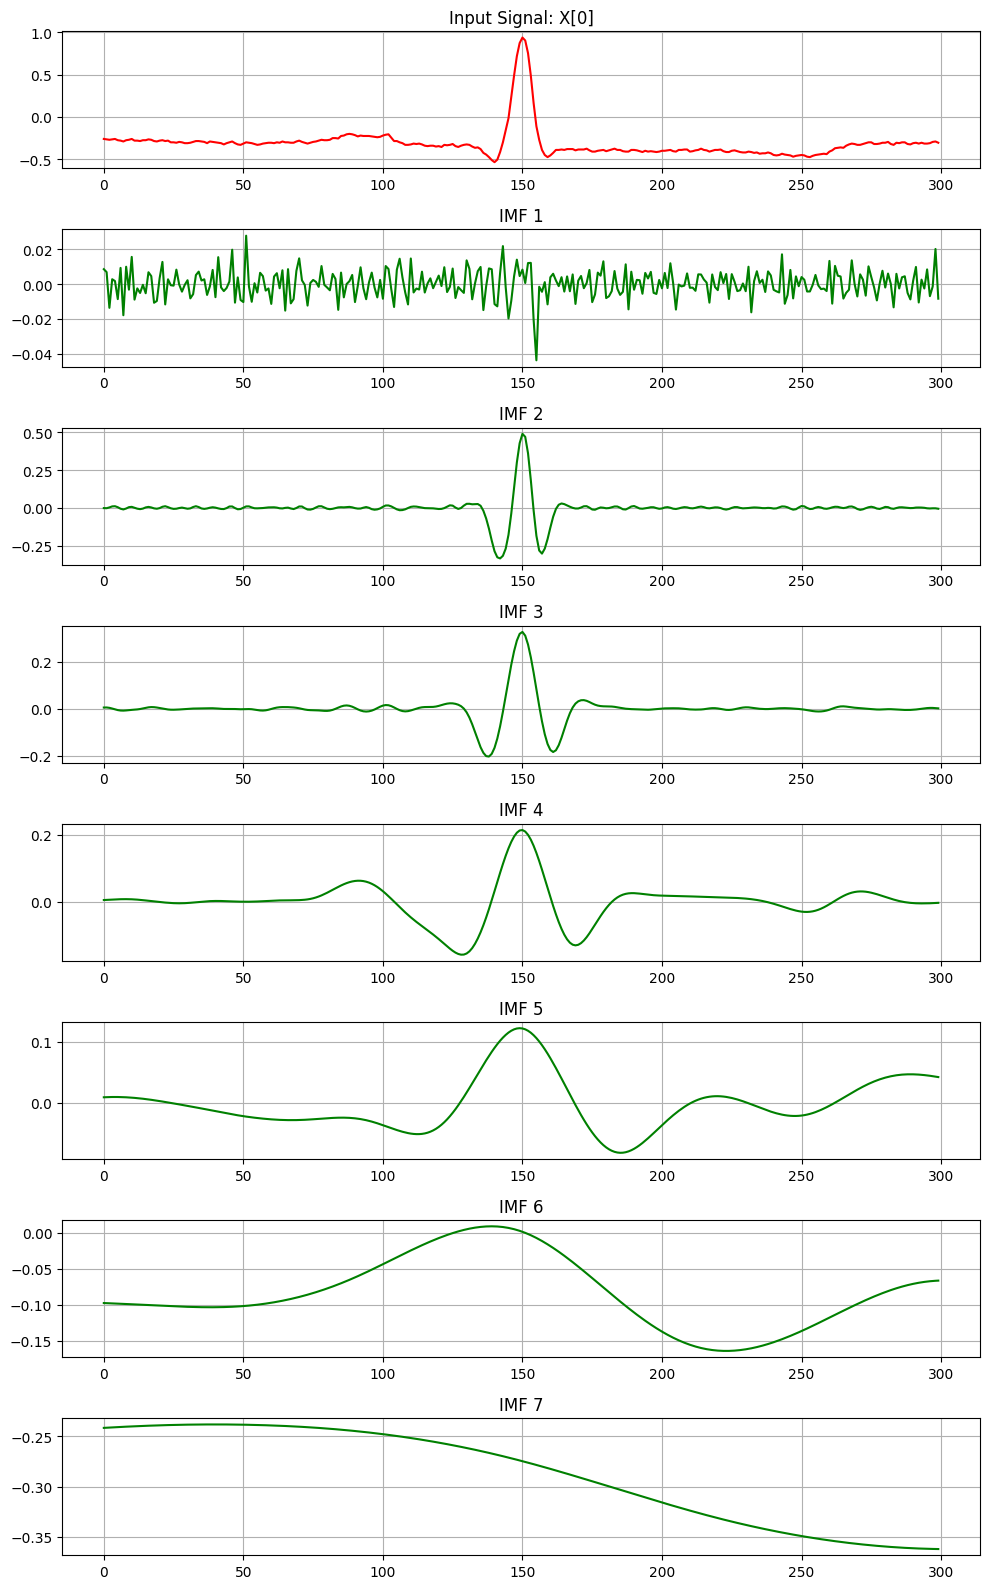

In [11]:
# Execute EEMD on signal
IMFs = eemd(X[0], max_imf=EEMD_IMFS)
N = IMFs.shape[0] # Number of subplots

plt.figure(figsize=(10, 2*N))  # Adjust the height based on the number of IMFs

# Plot the input signal
plt.subplot(N, 1, 1)
plt.plot(X[0], "r")
plt.title("Input Signal: X[0]")
plt.grid(True)

# Plot each IMF
for n, imf in enumerate(IMFs[:-1]):
    plt.subplot(N, 1, n + 2)
    plt.plot(imf, "g")
    plt.title(f"IMF {n + 1}")
    plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
train_features_df = get_features_df(train, "emd")
test_features_df = get_features_df(test, "emd")

print(train_features_df.shape)
print(test_features_df.shape)

Started extracting features
Decomposed segment 0; Extracted features from segment 0; Created a dataframe for segment 0.
Decomposed segment 1; Extracted features from segment 1; Created a dataframe for segment 1.
Decomposed segment 2; Extracted features from segment 2; Created a dataframe for segment 2.
Decomposed segment 3; Extracted features from segment 3; Created a dataframe for segment 3.
Decomposed segment 4; Extracted features from segment 4; Created a dataframe for segment 4.
Decomposed segment 5; Extracted features from segment 5; Created a dataframe for segment 5.
Decomposed segment 6; Extracted features from segment 6; Created a dataframe for segment 6.
Decomposed segment 7; Extracted features from segment 7; Created a dataframe for segment 7.
Decomposed segment 8; Extracted features from segment 8; Created a dataframe for segment 8.
Decomposed segment 9; Extracted features from segment 9; Created a dataframe for segment 9.
Decomposed segment 10; Extracted features from segme

In [13]:
train_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.016905,358.464325,4.536445,0.068598,0.024788,4073.482491,4.616699,0.071046,0.109779,42.538029,...,0.107524,0.067468,6.502805,4.006744,0.053513,0.000000,NaN,NaN,NaN,NaN
1,0.091701,8586.973083,1.006222,0.003375,0.318601,1149.124508,1.061952,0.003759,0.136816,103.033619,...,0.004653,0.249670,162.536927,1.245908,0.005174,0.067798,9.396344,1.388222,0.006424,0.0
2,1.136022,595.881207,0.116811,0.000045,0.285914,3130.818016,1.122074,0.004197,0.116106,11.482563,...,0.026675,0.058310,9.415610,2.651639,0.023437,0.000000,NaN,NaN,NaN,NaN
3,0.546884,8735.457008,0.769496,0.001974,0.089381,278.691713,1.267247,0.005353,0.251550,7.909382,...,0.011658,0.172852,35.864874,2.107354,0.014803,0.000000,NaN,NaN,NaN,NaN
4,0.992179,200.510574,0.818428,0.002233,0.453153,241954.522169,1.314924,0.005763,0.393355,25.204187,...,0.032647,0.045541,24.336853,6.295728,0.132121,0.000000,NaN,NaN,NaN,NaN


In [14]:
test_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.203407,8966.129865,1.216310,0.004931,0.043150,1493.179779,1.999352,0.013325,0.115618,224989.371285,...,0.023920,0.150751,19.257915,5.016626,0.083888,0.079531,14.096941,1.903225,0.012074,0.0
1,0.194593,3880.981361,1.882168,0.011809,0.204405,2602.116325,1.132470,0.004275,0.276883,17.829560,...,0.013886,0.093334,204.533786,0.557435,0.001036,0.000000,NaN,NaN,NaN,NaN
2,0.009952,178665.608780,4.004878,0.053463,0.023553,128.755027,4.676848,0.072910,0.136742,4468.803118,...,0.019751,0.176484,118.136147,2.523539,0.021228,0.000000,NaN,NaN,NaN,NaN
3,0.536975,570.840658,0.469830,0.000736,0.081432,52.808242,2.033737,0.013787,0.379780,202.496121,...,0.005646,0.211492,350.737753,2.203739,0.016188,0.122097,415.336448,3.354778,0.037515,0.0
4,0.031868,246.038875,1.402588,0.006558,0.286592,195.230676,1.436969,0.006883,0.186152,51.657879,...,0.017688,0.079642,8.492035,2.080781,0.014432,0.000000,NaN,NaN,NaN,NaN
